### predictions: 

In [4]:
from tensorflow import keras

2023-02-22 15:59:26.388548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy


def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2.0 * intersection + smooth) / (union + smooth), axis=0)


def dice_p_bce(in_gt, in_pred):
    return 0.05 * binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)


def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true) * K.flatten(K.round(y_pred))) / K.sum(y_true)


In [9]:
custom_objects = {
    'dice_p_bce': dice_p_bce,
    'dice_coef': dice_coef,
    'true_positive_rate': true_positive_rate,
}


In [10]:
import random
import numpy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
from matplotlib.path import Path
from skimage.color import label2rgb
      
        
from sklearn.model_selection import train_test_split

import multiprocessing
from skimage.util import montage as montage2d

import logging

In [11]:
# ------------------------------------------
# constants
# ------------------------------------------
EPOCHS = 1 #2
WORKERS = 1
MAX_STEPS_PER_EPOCH = 10 # 50 # 100
MAX_VAL_STEPS = 10 # 50 # 50
# ------------------------------------------
map_base_dir = "./input/"
map_img_dir = "./input/train/images/"
# ------------------------------------------



# ------------------------------------------
PLOT_FLAG = False
# ------------------------------------------


# ------------------------------------------
BLOCK_COUNT = 1
EDGE_CROP = 16
BASE_DEPTH = 16
SPATIAL_DROPOUT = 0.25
GAUSSIAN_NOISE = 0.1
BATCH_SIZE = 24
# ------------------------------------------


# ------------------------------------------
logging.info("starting...")
# ------------------------------------------
logging.info("EPOCHS: {}".format(EPOCHS))
logging.info("WORKERS: {}".format(WORKERS))
logging.info("MAX_STEPS_PER_EPOCH: {}".format(MAX_STEPS_PER_EPOCH))
logging.info("MAX_VAL_STEPS: {}".format(MAX_VAL_STEPS))
# ------------------------------------------


./input/train/images/000000236427.jpg
./input/train/images/000000003369.jpg
./input/train/images/000000091290.jpg
./input/train/images/000000064069.jpg
280741 + 2395553 -> 2395553


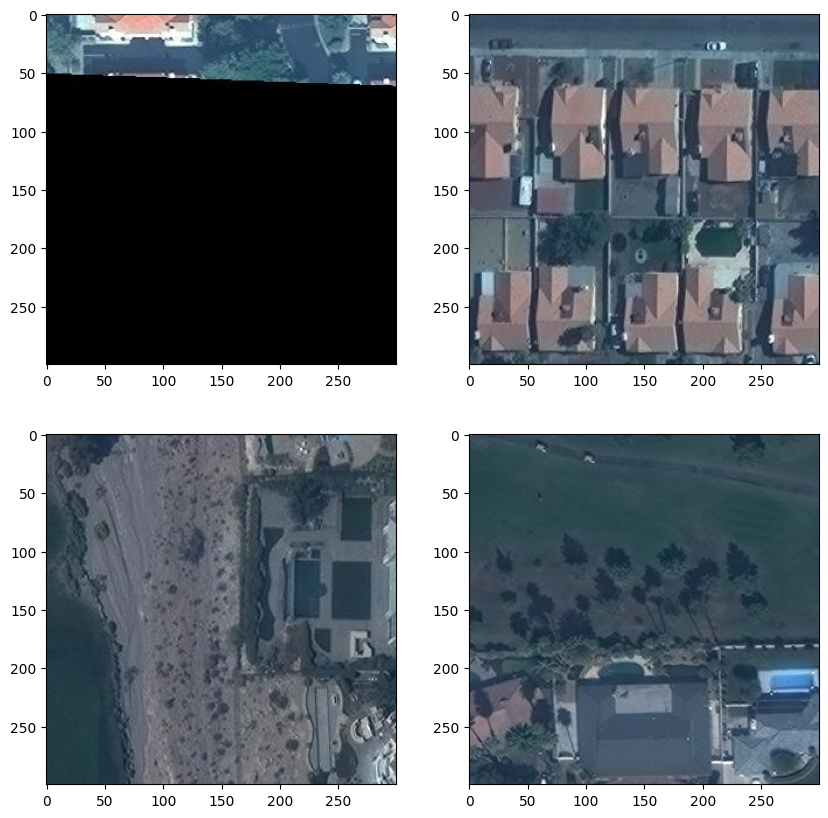

In [12]:
logging.info('reading annotations...')


json_path = os.path.join(map_base_dir, "annotation.json")
with open(json_path, "r") as f:
    annot_data = json.load(f)

logging.info('annotations read.')


logging.info('preparing dataframes...')

image_df = pd.DataFrame(annot_data["images"])
image_df.sample(3)
fig, m_axs = plt.subplots(2, 2, figsize=(10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    try:
        print(os.path.join(map_img_dir, c_row["file_name"]))
        img_data = imread(os.path.join(map_img_dir, c_row["file_name"]))
        c_ax.imshow(img_data)
    except:
        pass


annot_df = pd.DataFrame(annot_data["annotations"])
# annot_df.sample(3)


full_df = pd.merge(
    annot_df, image_df, how="left", left_on="image_id", right_on="id"
).dropna()
print(image_df.shape[0], "+", annot_df.shape[0], "->", full_df.shape[0])
full_df.sample(2)



logging.info('dataframes prepared.')


def create_boxes(in_rows):
    # TODO: this seems to get a few of the boxes wrong so we stick
    #  to segmentation polygons instead
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox from the coco standard
        (start_y, start_x, wid_y, wid_x) = in_row["bbox"]

        box_list += [Rectangle((start_x, start_y), wid_y, wid_x)]
    return box_list


if PLOT_FLAG: 
    fig, m_axs = plt.subplots(2, 2, figsize=(10, 10))
    for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby("image_id")):
        print("=" * 80)
        img_data = imread(os.path.join(map_img_dir, c_df["file_name"].values[0]))
        c_ax.imshow(img_data)

        # c_ax.add_collection(PatchCollection(create_boxes(c_df), alpha = 0.25, facecolor = 'red'))
        for _, c_row in c_df.iterrows():
            print("-" * 80)
            print("row:", c_row)

            xy_vec = np.array(c_row["segmentation"]).reshape((-1, 2))
            c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label=c_df["id_x"])





# # Convert Polygons to Segmentations
# We can use the `Path` function of matplotlib on a `np.meshgrid` of $x,y$ values
# in order to convert the polygon into a binary image to use as the segmentation.


def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), range(in_img.shape[1]), indexing="ij")

    out_img = np.zeros(in_img.shape[:2])

    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row["segmentation"]).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label=in_df["id_x"])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(
            np.stack([yy.ravel(), xx.ravel()], -1)
        ).reshape(out_img.shape)
    return out_img


if PLOT_FLAG:
    fig, m_axs = plt.subplots(3, 3, figsize=(15, 20))
    for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs, full_df.groupby("image_id")):
        img_data = imread(os.path.join(map_img_dir, c_df["file_name"].values[0]))
        c_ax.imshow(img_data)
        out_img = rows_to_segmentation(img_data, c_df)
        rgba_img = np.concatenate(
            [
                img_data,
                np.clip(np.expand_dims(127 * out_img + 127, -1), 0, 255).astype(np.uint8),
            ],
            -1,
        )
        d_ax.imshow(rgba_img)

        f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label=0))

  

In [13]:
train_ids, valid_ids = train_test_split(image_df["id"], test_size=0.25)
train_df = full_df[full_df["image_id"].isin(train_ids)]
valid_df = full_df[full_df["image_id"].isin(valid_ids)]
print(train_df.shape[0], "training boxes")
print(valid_df.shape[0], "validation boxes")



# In[25]:


# ### helper:
#
# - these are the type and lens of the object
#
# - type, len:  <class 'tuple'> 2
#
# - types:  <class 'int'> <class 'pandas.core.frame.DataFrame'>
#
# - keys of the data frame:
# - 'id_x',
# - 'image_id',
# - 'segmentation',
# - 'area',
# - 'bbox',
# - 'category_id',
# - 'iscrowd',
# - 'id_y',
# - 'file_name',
# - 'width',
# - 'height'


def batch_img_gen(in_df, batch_size):
    #     all_groups = list(in_df.groupby(['image_id']))
    lst_of_dataframes = list(zip(*(valid_df.groupby(["image_id"]))))[1]
    # lst_of_dataframes = list([e for e, _ in zip(*(valid_df.groupby(["image_id"])))])
    out_img, out_seg = [], []
    while True:
        #         for (_, c_df) in np.random.permutation(all_groups):

        # random shiffling

        len_lst_dataframes = len(lst_of_dataframes)
        for indx in np.random.permutation(range(len_lst_dataframes)):
            c_df = lst_of_dataframes[indx]
            img_data = imread(os.path.join(map_img_dir, c_df["file_name"].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img) >= batch_size:
                yield (np.stack(out_img, 0) / 255.0).astype(np.float32), np.stack(
                    out_seg, 0
                ).astype(np.float32)
                out_img, out_seg = [], []



# ---------------------
# original version
# ---------------------

# def batch_img_gen(in_df, batch_size):
#     all_groups = list(in_df.groupby(['image_id']))
#     out_img, out_seg = [], []
#     while True:
#         for (_, c_df) in np.random.permutation(all_groups):
#             img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
#             out_img += [img_data]
#             out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
#             if len(out_img) >= batch_size:
#                 yield (np.stack(out_img, 0)/255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
#                 out_img, out_seg = [], []



valid_gen = batch_img_gen(valid_df, 8)

1797330 training boxes
598223 validation boxes


/tmp/ipykernel_5739/290011526.py:36: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  lst_of_dataframes = list(zip(*(valid_df.groupby(["image_id"]))))[1]


x (8, 300, 300, 3) float32 0.0 1.0
y (8, 300, 300, 1) float32 0.0 1.0
1/1 [==============================] - 2s 2s/step


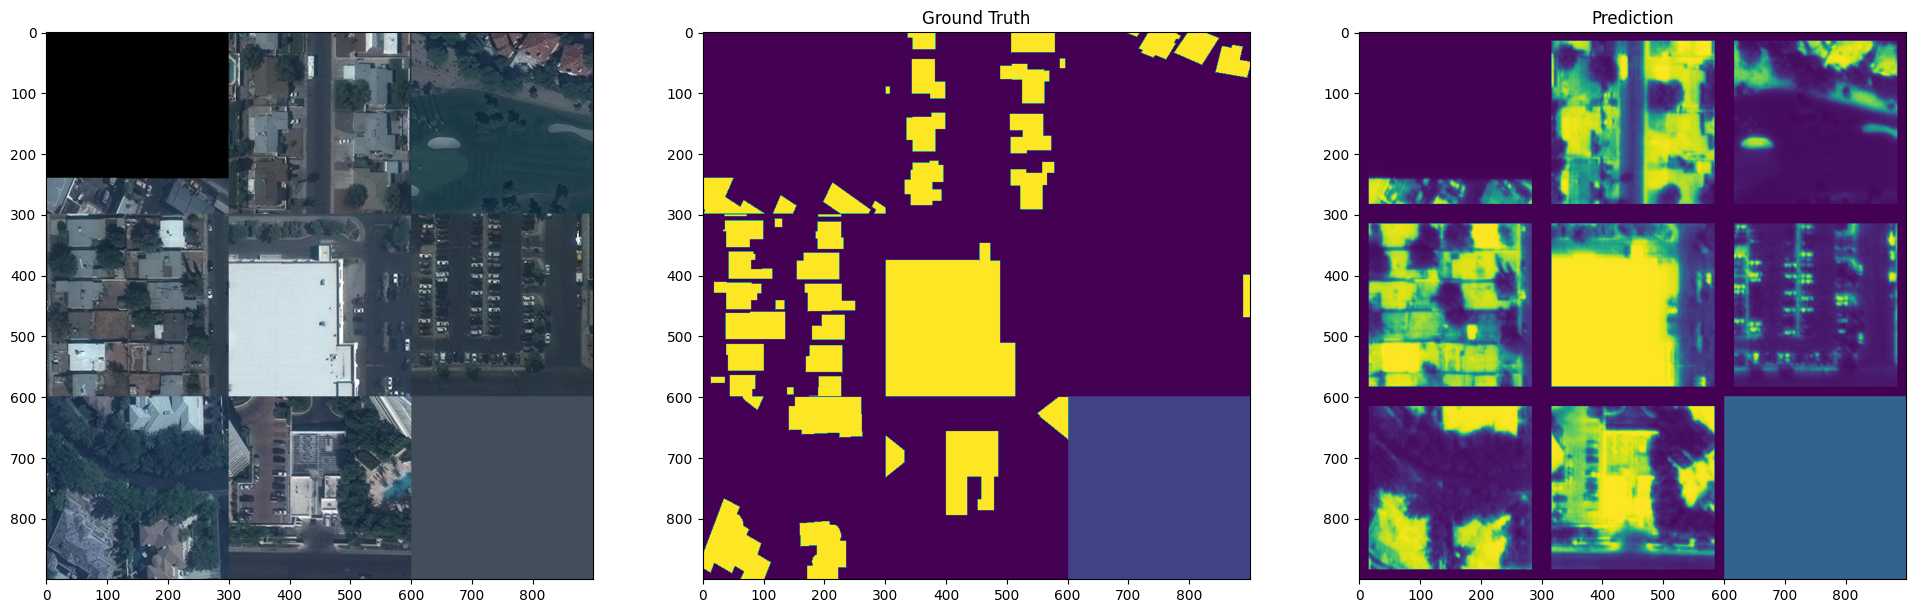

In [15]:
# import keras
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("model_20230222_134239", custom_objects=custom_objects)



logging.info("predictions...")


t_x, t_y = next(valid_gen)
if t_x.shape[0] > 16:
    t_x = t_x[:16]
    t_y = t_y[:16]

print("x", t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print("y", t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = reconstructed_model.predict(t_x)



def get_utc_timestamp_formatted(time_format: str = "%Y%m%d_%H%M%S") -> str:
    from datetime import datetime
    return datetime.utcnow().strftime(time_format)

utc_timestamp = get_utc_timestamp_formatted()



logging.info("predictions done.")


FIGSIZE = (24, 16)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=FIGSIZE)
montage_rgb = lambda x: np.stack(
    [montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1
)

CMAP = "bone_r"
CMAP = plt.cm.gray
CMAP = plt.cm.viridis

ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap=CMAP)
ax2.set_title("Ground Truth")
ax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap=CMAP)
ax3.set_title("Prediction")

fig_path = "./fig_prediction_{}.png".format(utc_timestamp)
fig.savefig(fig_path, dpi=300)
logging.info("predictions plotted at {} .".format(fig_path))
logging.info("-" * 80)

In [ ]:
pred_y